Basic model design

In [1]:
import mesa


class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N):
        self.num_agents = N
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)

Introducing time and scheduling

In [23]:
import mesa


class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def step(self):
        # The agent's step will go here.
        # For demonstration purposes we will print the agent's unique_id
        print("Hi, I am agent " + str(self.unique_id) + ". My wealth is " + str(self.wealth))


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N):
        self.num_agents = N
        self.schedule = mesa.time.RandomActivation(self)
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)

    def step(self):
        """Advance the model by one step."""
        self.schedule.step() # randomly selects from all agents

Can iterate one step of the model as shown below:

In [24]:
empty_model = MoneyModel(10)
empty_model.step() 

Hi, I am agent 2. My wealth is 1
Hi, I am agent 9. My wealth is 1
Hi, I am agent 0. My wealth is 1
Hi, I am agent 4. My wealth is 1
Hi, I am agent 7. My wealth is 1
Hi, I am agent 8. My wealth is 1
Hi, I am agent 5. My wealth is 1
Hi, I am agent 6. My wealth is 1
Hi, I am agent 1. My wealth is 1
Hi, I am agent 3. My wealth is 1


Rewriting agent step method to undergo an exchange (random exchange of wealth)

In [28]:
class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def step(self):
        if self.wealth == 0:
            return
        other_agent = self.random.choice(self.model.schedule.agents)
        # print(f'self:{self.unique_id}, other:{other_agent.unique_id}')
        other_agent.wealth += 1
        self.wealth -= 1


Running this model

In [29]:
model = MoneyModel(10)
for i in range(10):
    model.step()

We now want to visualise this data

(array([4., 0., 4., 0., 0., 1., 0., 0., 0., 1.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

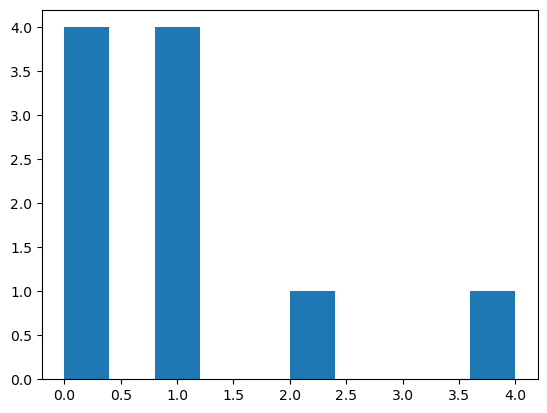

In [31]:
# The below is needed for both notebooks and scripts
import matplotlib.pyplot as plt

agent_wealth = [a.wealth for a in model.schedule.agents]
plt.hist(agent_wealth)

Can repeat these runs to see the distribution that emerges from them 

- This is an alternative to doing a run with many individuals

(array([440., 297., 150.,  68.,  30.,  15.]),
 array([0, 1, 2, 3, 4, 5, 6]),
 <BarContainer object of 6 artists>)

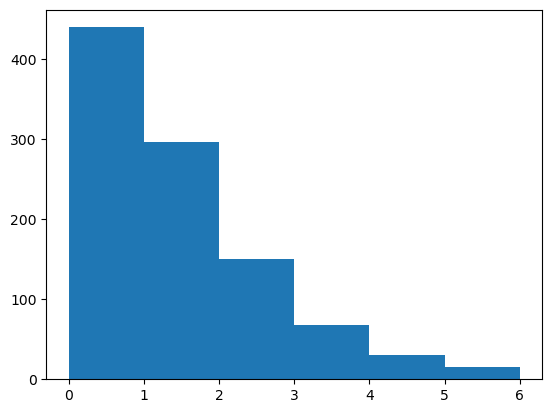

In [34]:
all_wealth = []
# This runs the model 100 times, each model executing 10 steps.
for j in range(100):
    # Run the model
    model = MoneyModel(10)
    for i in range(10):
        model.step()

    # Store the results
    for agent in model.schedule.agents:
        all_wealth.append(agent.wealth)

plt.hist(all_wealth, bins=range(max(all_wealth) + 1))


# Adding Space
We can use a mesa grid to add a spatial component.

Each agent inherently has a pos variable with an (x,y) coordinate tuple. The place_agent method adds this attribute to the agent.

In [19]:
class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = mesa.space.MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)

            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

We now need to add a movement function.

This can be done using the get_neighborhood function which tells the agent the occupancy of neighbouring cells.

In [ ]:
def move(self):
    possible_steps = self.model.grid.get_neighborhood(
        self.pos,
        moore=True,
        include_center=False)
    new_position = self.random.choice(possible_steps)
    self.model.grid.move_agent(self, new_position)
    
setattr(MoneyAgent, 'move', move)

In [35]:
class MoneyAgent(mesa.Agent):
    """An agent with fixed initial wealth."""

    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other_agent = self.random.choice(cellmates)
            other_agent.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = mesa.space.MultiGrid(width, height, True)
        self.schedule = mesa.time.RandomActivation(self)
        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

    def step(self):
        self.schedule.step()

In [36]:
model = MoneyModel(50, 10, 10)
for i in range(20):
    model.step()

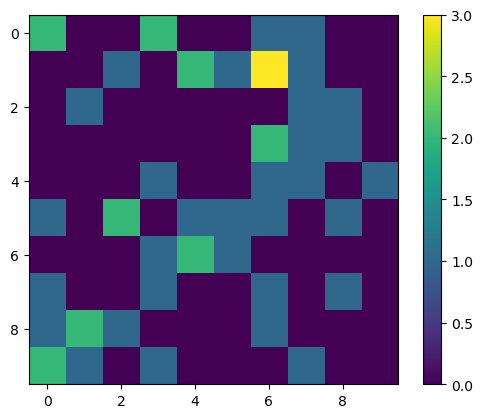

In [37]:
import numpy as np

agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
plt.imshow(agent_counts, interpolation="nearest")
plt.colorbar()

# If running from a text editor or IDE, remember you'll need the following:
# plt.show()